In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.ticker as ticker
from datetime import datetime
import random
from scipy import signal

In [2]:
class Function:
    # Конструктор класса
    def __init__(self, start=None, end=None, step=None):
        if start is not None and end is not None and step is not None:
            self.initializeX(start, end, step)
            self.initializeY()
    
    # Инициализатор шкалы X
    def initializeX(self, start, end, step):
        self.start = start
        self.end = end
        self.step = step
        self.length = int(np.ceil(np.abs(end - start) / step))
        self.X = np.arange(start, end, step)
    
    # Инициализатор шкалы Y
    def initializeY(self):
        self.Y = np.zeros(self.length)
        
    # Функция полигармонического процесса
    def complex_sin(self, arrA, arrF):
        for i in range(0, len(arrA)):
            self.Y += arrA[i] * np.sin(2 * np.pi * arrF[i] * self.X)
        
    # Вычитание функций
    def minus_func(self, arrFunc):
        self.Y = 0
        for i in range(0, len(arrFunc)):
            self.Y -= arrFunc[i].Y.copy()
        
    # Тренд
    def trend(self, func):
        L = func.length - self.length
        for m in range(0, self.length):
            sum = 0
            for k in range(m, m + L):
                sum += func.Y[k]
            self.Y[m] = sum / L
            
    # Подавление тренда
    def anti_trend(self, func, trend):
        L = func.length - trend.length
        self.X = np.array(list(func.X[:func.length - L]))
        self.Y = np.array(list(func.Y[:func.length - L])) - trend.Y
        self.length = len(self.X)
        
    # Амплитудный спектр Фурье
    def fourier_spectrum(self, func, window, freq=False, half=False, dt=1):
        lenZeros = int(func.length * (1 - window) / 2)
        for i in range(0, lenZeros):
            func.Y[i] = 0
            func.Y[N - i - 1] = 0
        sumRe, sumIm = 0, 0
        for k in range(0, func.length):
            sumRe += func.Y[k] * np.cos(2 * np.pi * self.X * k / func.length)
            sumIm += func.Y[k] * np.sin(2 * np.pi * self.X * k / func.length)
        Re = (1 / func.length) * sumRe
        Im = (1 / func.length) * sumIm
        self.Y = (Re ** 2 + Im ** 2) ** 0.5
        if freq:
            # переходим от параметра n к f
            df = 1 / (self.end * dt)
            self.initializeX(self.start, self.end * df, df)
        if half:
            # берём первую половину графика
            self.initializeX(self.start, int(self.end / 2), self.step)
            self.Y = np.array(list(self.Y)[:self.length])
          
    # Фазовый спектр Фурье
    def phase_spectrum(self, func, window, freq=False, half=False, dt=1):
        lenZeros = int(func.length * (1 - window) / 2)
        for i in range(0, lenZeros):
            func.Y[i] = 0
            func.Y[N - i - 1] = 0
        sumRe, sumIm = 0, 0
        for k in range(0, func.length):
            sumRe += func.Y[k] * np.cos(2 * np.pi * self.X * k / func.length)
            sumIm += func.Y[k] * np.sin(2 * np.pi * self.X * k / func.length)
        Re = (1 / func.length) * sumRe
        Im = (1 / func.length) * sumIm
        self.Y = np.arctan(Im / Re)
        if freq:
            # переходим от параметра n к f
            df = 1 / (self.end * dt)
            self.initializeX(self.start, self.end * df, df)
        if half:
            # берём первую половину графика
            self.initializeX(self.start, int(self.end / 2), self.step)
            self.Y = np.array(list(self.Y)[:self.length])
         
    # Функция восстановления сигнала по гармоникам
    def restore_signal(self, amplitude_spectr, phase_spectr, threshold):
        for i in range(0, amplitude_spectr.length):
            if amplitude_spectr.Y[i] > threshold:
                self.Y += 2 * amplitude_spectr.Y[i] * np.sin(2 * np.pi * amplitude_spectr.X[i] * self.X + phase_spectr.Y[i])
        
    # Прочитать файл и выбрать данные
    def read(self, path, enc, date_format):
        self.X = []
        self.Y = []
        with open(path, 'r', encoding=enc) as file:
            for line in file:
                lineSplit = line.split('\t')
                try:
                    self.Y.append(float(lineSplit[1]))
                    date = datetime.strptime(lineSplit[4].replace('\n', ''), date_format)
                    self.X.append(date)
                except:
                    pass
        self.length = len(self.X)
        self.X = np.array(self.X)
        self.Y = np.array(self.Y)
    
    # Конвертация данныых в строковый тип
    def convert_to_str(self, attribute):
        if attribute == 'price':
            conv_attr = self.Y
        elif attribute == 'date':
            conv_attr = self.X
        for i in range(0, len(conv_attr)):
            conv_attr[i] = str(conv_attr[i])
            
    # Перевернуть шкалу
    def reverse(self):
        self.Y = np.flip(self.Y)
        self.X = np.flip(self.X)
        
    # Обрезать данные
    def cut(self, num):
        cut_date = []
        cut_price = []
        for i in range(0, len(self.X)):
            if i % num == 0:
                cut_date.append(self.X[i])
                cut_price.append(self.Y[i])
        self.X = np.array(cut_date)
        self.Y = np.array(cut_price)
        self.length = len(self.X)
    
    # Отобразить график функции
    def display(self, title, xlabel='x', ylabel='y'):
        plt.plot(self.X, self.Y)
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.grid(True)
        
class Display:
    @staticmethod
    def show(func, xa, ya, rot=90, title='', xl='', yl=''):
        fig, ax = plt.subplots()
        ax.plot(func.X, func.Y, color='black')
        ax.xaxis.set_major_locator(ticker.MultipleLocator(xa))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(ya))
        plt.xticks(rotation = rot)
        plt.title(title)
        plt.xlabel(xl)
        plt.ylabel(yl)
        fig.set_figwidth(15)
        fig.set_figheight(5)
        plt.grid(True)
        plt.show()
        
    @staticmethod
    def show_func_trend(func, trend, xa, ya, rot=90, title='', xl='', yl=''):
        fig, ax = plt.subplots()
        ax.plot(func.X, func.Y, color='black')
        ax.plot(trend.X, trend.Y, color='red')
        ax.xaxis.set_major_locator(ticker.MultipleLocator(xa))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(ya))
        plt.xticks(rotation = rot)
        plt.title(title)
        plt.xlabel(xl)
        plt.ylabel(yl)
        fig.set_figwidth(15)
        fig.set_figheight(5)
        plt.grid(True)
        plt.show()

def get_A_f(func, threshold):
    A = []
    f = []
    for i in range(1, func.length):
        if func.Y[i] > threshold:
            A.append(func.Y[i] * 2)
            f.append(func.X[i])
    return {'A': A, 'f': f}

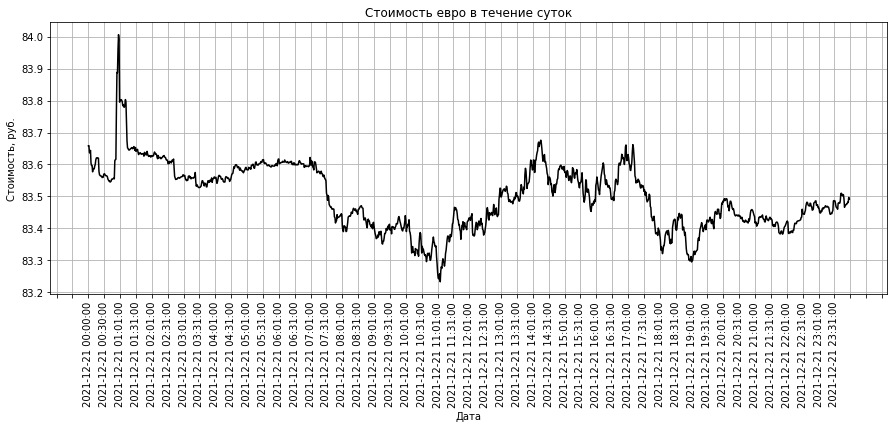

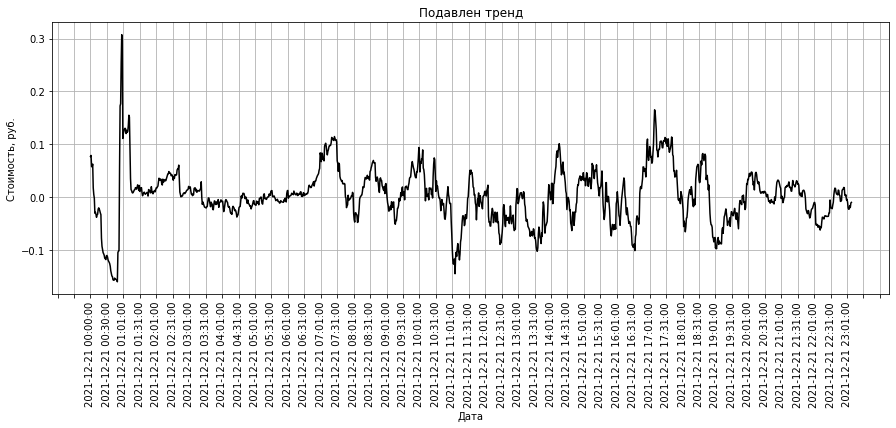

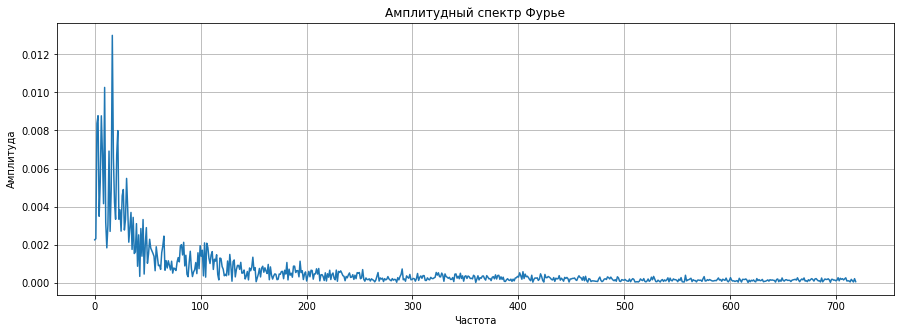

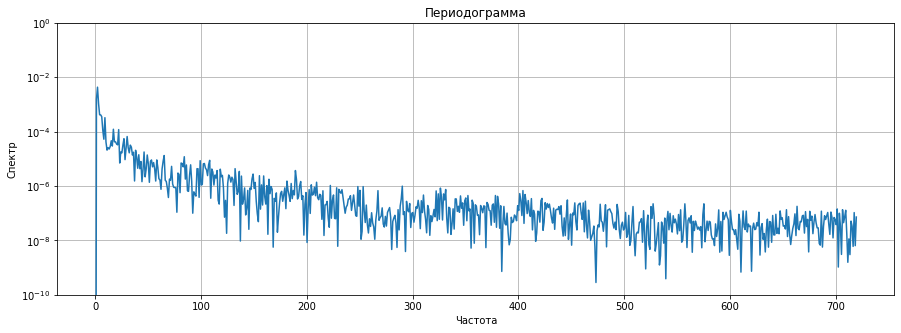

In [3]:
L = 50
start = 0
step = 1
window = 1
dt = 1 / 1440

# Курс доллара поминутно в течение суток
file_1_min = Function()
file_1_min.read('1_day_eur.txt', 'utf-8', "%d.%m.%Y %H:%M")
file_1_min.convert_to_str('date')
file_1_min.reverse()

# Тренд курса доллара
trend = Function(start, file_1_min.length - L, step)
trend.trend(file_1_min)

Display.show(file_1_min, 30, 0.1, 90, 'Стоимость евро в течение суток', 'Дата', 'Стоимость, руб.')
# Display.show_func_trend(file_1_min, trend, 30, 0.1, 90, 'Стоимость доллара в течение суток', 'Дата', 'Стоимость, руб.')

# Подавляется тренд
anti_trend = Function()
anti_trend.anti_trend(file_1_min, trend)

Display.show(anti_trend, 30, 0.1, 90, 'Подавлен тренд', 'Дата', 'Стоимость, руб.')

# Амплитудный спектр Фурье
fourier = Function(start, anti_trend.length, step)
fourier.fourier_spectrum(anti_trend, window, True, True, dt)
plt.figure(figsize=(15, 5))
fourier.display('Амплитудный спектр Фурье', 'Частота', 'Амплитуда')

# Фазовый спектр Фурье
phase = Function(start, anti_trend.length, step)
phase.phase_spectrum(anti_trend, window, True, True, dt)

# Периодограмма
plt.figure(figsize=(15, 5))
f, Pxx = signal.periodogram(file_1_min.Y, 1 / dt)
plt.semilogy(f, Pxx)
plt.ylim([1e-10, 1e0])
plt.title('Периодограмма')
plt.ylabel('Спектр')
plt.xlabel('Частота')
plt.grid(True)
plt.show()

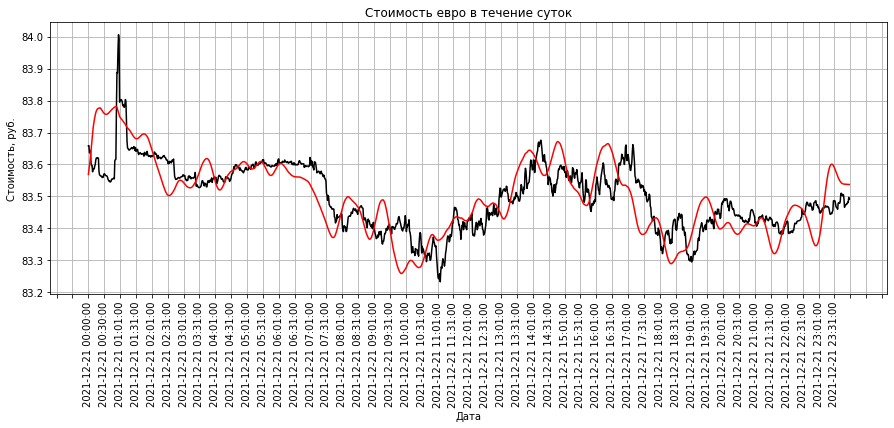

In [4]:
restored = Function(0, file_1_min.length * dt, dt)
restored.restore_signal(fourier, phase, 0.003)

restored.Y = restored.Y + np.array(list(trend.Y) + [trend.Y[trend.length - 1]] * L)
restored.X = file_1_min.X

Display.show_func_trend(file_1_min, restored, 30, 0.1, 90, 'Стоимость евро в течение суток', 'Дата', 'Стоимость, руб.')

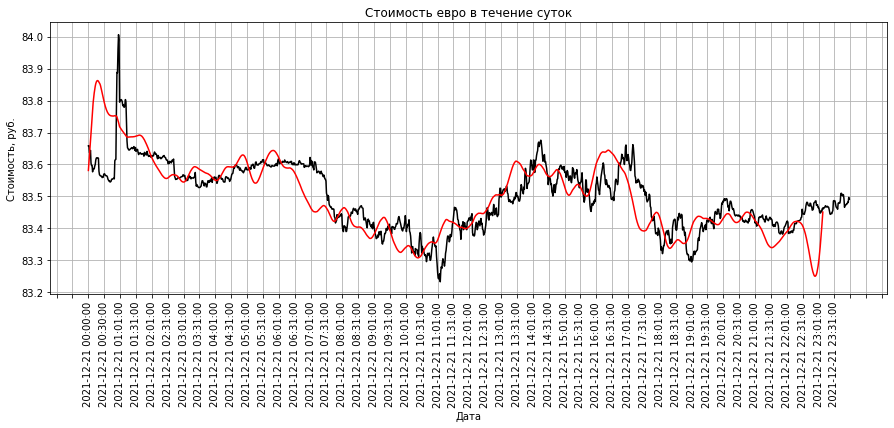

In [5]:
params = get_A_f(fourier, 0.003)
approximation = Function(0, trend.length * dt, dt)
approximation.complex_sin(params['A'], params['f'])
approximation.X = trend.X
approximation.Y = approximation.Y + trend.Y

Display.show_func_trend(file_1_min, approximation, 30, 0.1, 90, 'Стоимость евро в течение суток', 'Дата', 'Стоимость, руб.')

In [6]:
arr = np.array([trend.Y, file_1_min.Y[:file_1_min.length - L]], float)
corr = np.corrcoef(arr)
print('Correlation with trend:')
print(corr)

Correlation with trend:
[[1.         0.86761966]
 [0.86761966 1.        ]]


In [7]:
arr = np.array([restored.Y, file_1_min.Y], float)
corr = np.corrcoef(arr)
print('Correlation with restored:')
print(corr)

Correlation with restored:
[[1.         0.76707359]
 [0.76707359 1.        ]]


In [8]:
arr = np.array([approximation.Y, file_1_min.Y[:file_1_min.length - L]], float)
corr = np.corrcoef(arr)
print('Correlation with approximation:')
print(corr)

Correlation with approximation:
[[1.         0.77585427]
 [0.77585427 1.        ]]


In [9]:
print(len(params['A']))
print(len(params['f']))

29
29


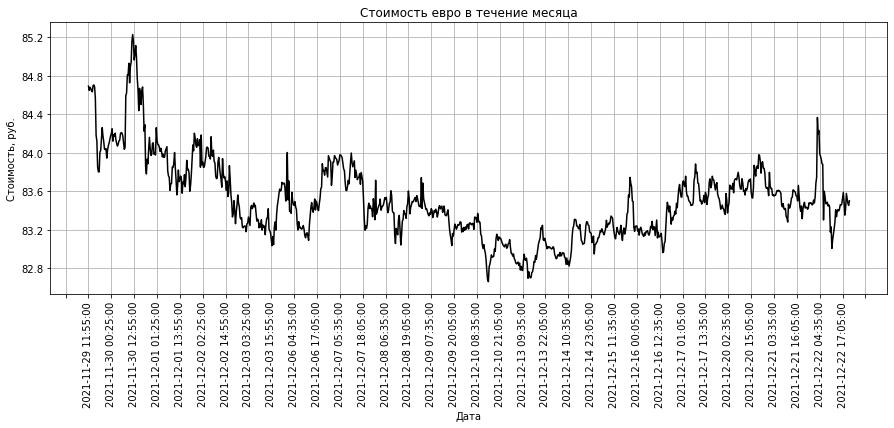

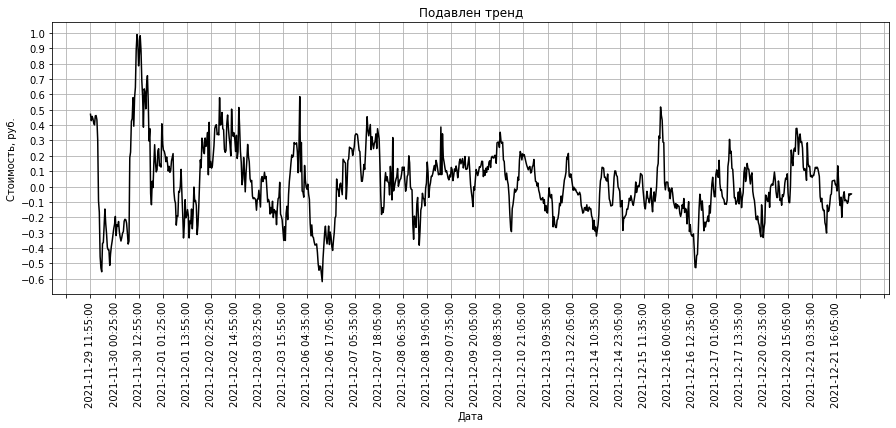

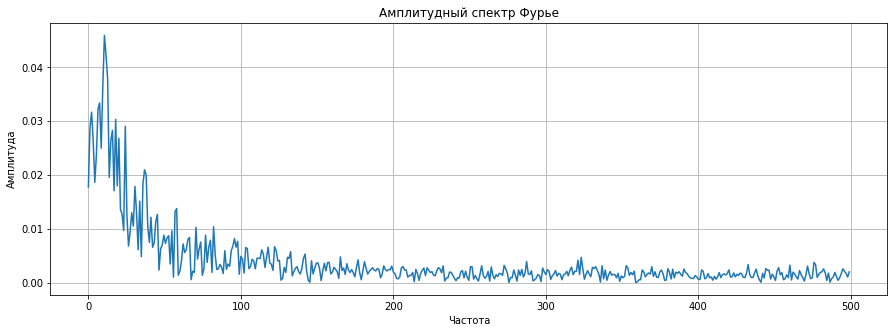

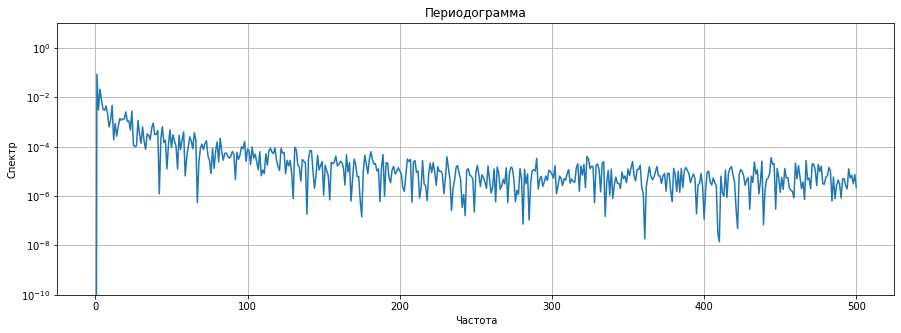

In [10]:
L = 50
start = 0
step = 1
window = 1
dt = 1 / 1000

# Курс доллара в течение месяца
file_5_min = Function()
file_5_min.read('1_month_eur.txt', 'utf-8', "%d.%m.%Y %H:%M")
file_5_min.convert_to_str('date')
file_5_min.reverse()
file_5_min.cut(5)

# Тренд курса доллара
trend = Function(start, file_5_min.length - L, step)
trend.trend(file_5_min)

Display.show(file_5_min, 30, 0.4, 90, 'Стоимость евро в течение месяца', 'Дата', 'Стоимость, руб.')
# Display.show_func_trend(file_5_min, trend, 30, 0.4, 90, 'Стоимость доллара в течение месяца', 'Дата', 'Стоимость, руб.')

# Подавляется тренд
anti_trend = Function()
anti_trend.anti_trend(file_5_min, trend)

Display.show(anti_trend, 30, 0.1, 90, 'Подавлен тренд', 'Дата', 'Стоимость, руб.')

# Амплитудный спектр Фурье
fourier = Function(start, anti_trend.length, step)
fourier.fourier_spectrum(anti_trend, window, True, True, dt)
plt.figure(figsize=(15, 5))
fourier.display('Амплитудный спектр Фурье', 'Частота', 'Амплитуда')

# Фазовый спектр Фурье
phase = Function(start, anti_trend.length, step)
phase.phase_spectrum(anti_trend, window, True, True, dt)

# Периодограмма
plt.figure(figsize=(15, 5))
f, Pxx = signal.periodogram(file_5_min.Y, 1 / dt)
plt.semilogy(f, Pxx)
plt.ylim([1e-10, 10])
plt.title('Периодограмма')
plt.xlabel('Частота')
plt.ylabel('Спектр')
plt.grid(True)
plt.show()

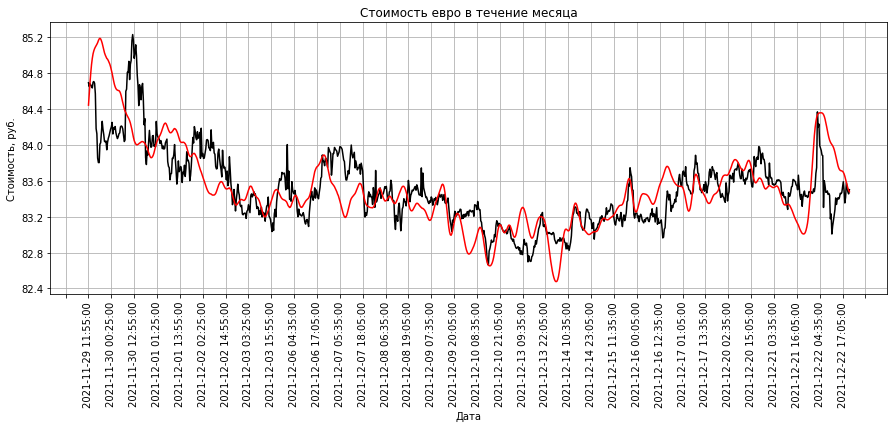

In [11]:
restored = Function(0, file_5_min.length * dt, dt)
restored.restore_signal(fourier, phase, 0.01)

restored.Y = restored.Y + np.array(list(trend.Y) + [trend.Y[trend.length - 1]] * L)
restored.X = file_5_min.X

Display.show_func_trend(file_5_min, restored, 30, 0.4, 90, 'Стоимость евро в течение месяца', 'Дата', 'Стоимость, руб.')

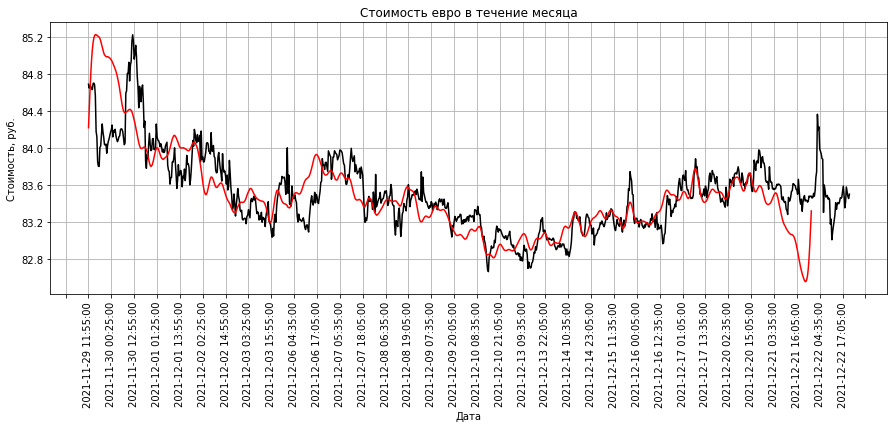

In [12]:
params = get_A_f(fourier, 0.01)
approximation = Function(0, trend.length * dt, dt)
approximation.complex_sin(params['A'], params['f'])
approximation.X = trend.X
approximation.Y = approximation.Y + trend.Y

Display.show_func_trend(file_5_min, approximation, 30, 0.4, 90, 'Стоимость евро в течение месяца', 'Дата', 'Стоимость, руб.')

In [13]:
arr = np.array([trend.Y, file_5_min.Y[:file_5_min.length - L]], float)
corr = np.corrcoef(arr)
print('Correlation with trend:')
print(corr)

Correlation with trend:
[[1.         0.83897678]
 [0.83897678 1.        ]]


In [14]:
arr = np.array([restored.Y, file_5_min.Y], float)
corr = np.corrcoef(arr)
print('Correlation with restored:')
print(corr)

Correlation with restored:
[[1.         0.73396996]
 [0.73396996 1.        ]]


In [15]:
arr = np.array([approximation.Y, file_5_min.Y[:file_5_min.length - L]], float)
corr = np.corrcoef(arr)
print('Correlation with approximation:')
print(corr)

Correlation with approximation:
[[1.         0.77832905]
 [0.77832905 1.        ]]


In [16]:
print(len(params['A']))
print(len(params['f']))

39
39


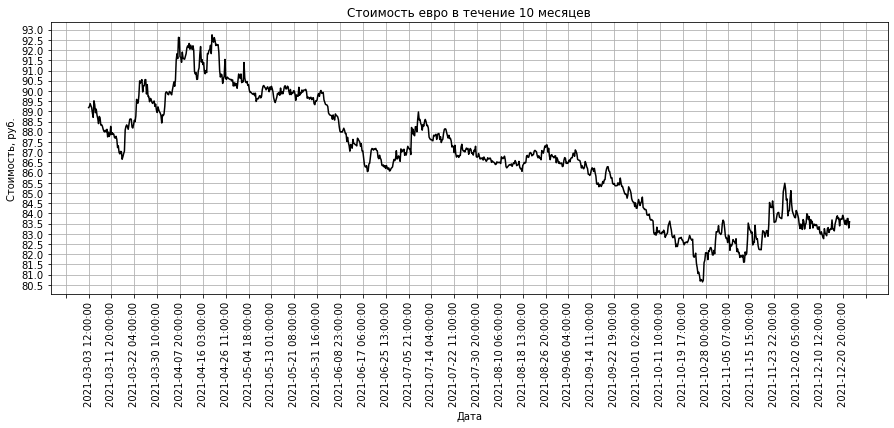

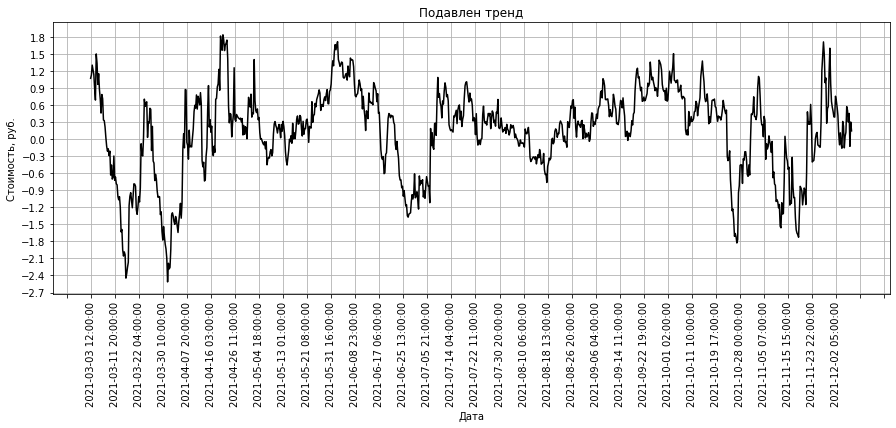

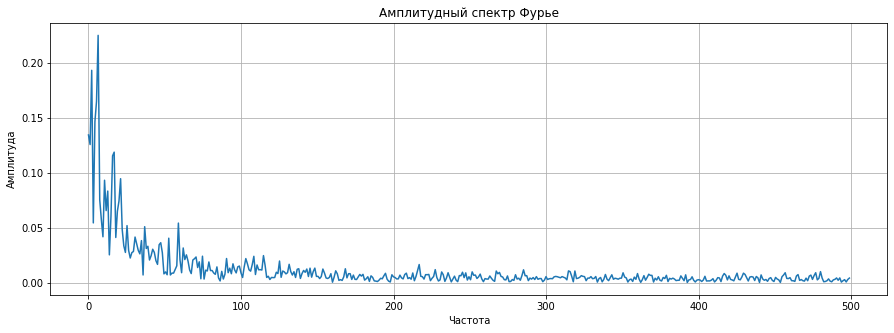

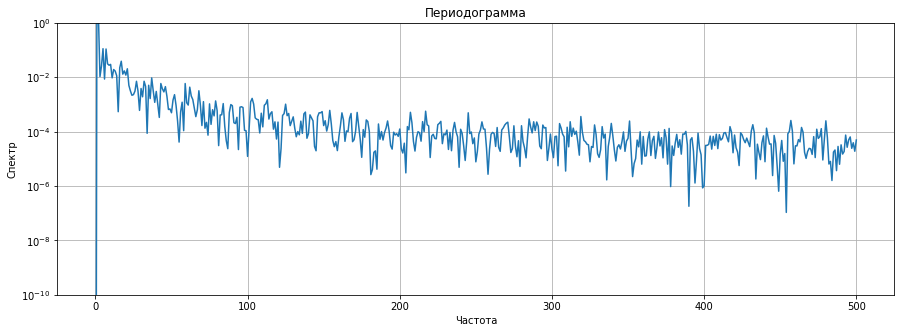

In [17]:
L = 50
start = 0
step = 1
window = 1
dt = 1 / 1000

# Курс доллара в течение 10 месяцев
file_1_hour = Function()
file_1_hour.read('10_months_eur.txt', 'utf-8', "%d.%m.%Y %H")
file_1_hour.convert_to_str('date')
file_1_hour.reverse()
file_1_hour.cut(5)

# Тренд курса доллара
trend = Function(start, file_1_hour.length - L, step)
trend.trend(file_1_hour)

Display.show(file_1_hour, 30, 0.5, 90, 'Стоимость евро в течение 10 месяцев', 'Дата', 'Стоимость, руб.')
# Display.show_func_trend(file_1_hour, trend, 30, 0.5, 90, 'Стоимость доллара в течение 10 месяцев', 'Дата', 'Стоимость, руб.')

# Подавляется тренд
anti_trend = Function()
anti_trend.anti_trend(file_1_hour, trend)

Display.show(anti_trend, 30, 0.3, 90, 'Подавлен тренд', 'Дата', 'Стоимость, руб.')

# Амплитудный спектр Фурье
fourier = Function(start, anti_trend.length, step)
fourier.fourier_spectrum(anti_trend, window, True, True, dt)
plt.figure(figsize=(15, 5))
fourier.display('Амплитудный спектр Фурье', 'Частота', 'Амплитуда')

# Фазовый спектр Фурье
phase = Function(start, anti_trend.length, step)
phase.phase_spectrum(anti_trend, window, True, True, dt)

# Периодограмма
plt.figure(figsize=(15, 5))
f, Pxx = signal.periodogram(file_1_hour.Y, 1 / dt)
plt.semilogy(f, Pxx)
plt.ylim([1e-10, 1e0])
plt.title('Периодограмма')
plt.xlabel('Частота')
plt.ylabel('Спектр')
plt.grid(True)
plt.show()

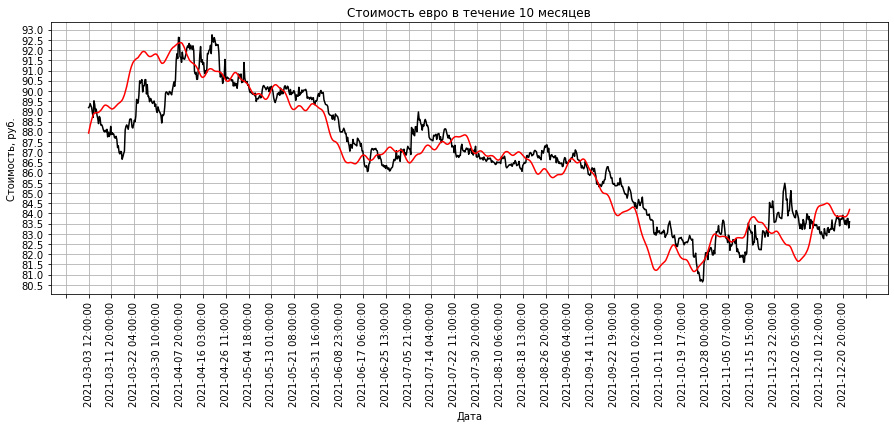

In [18]:
restored = Function(0, file_1_hour.length * dt, dt)
restored.restore_signal(fourier, phase, 0.05)

restored.Y = restored.Y + np.array(list(trend.Y) + [trend.Y[trend.length - 1]] * L)
restored.X = file_1_hour.X

Display.show_func_trend(file_1_hour, restored, 30, 0.5, 90, 'Стоимость евро в течение 10 месяцев', 'Дата', 'Стоимость, руб.')

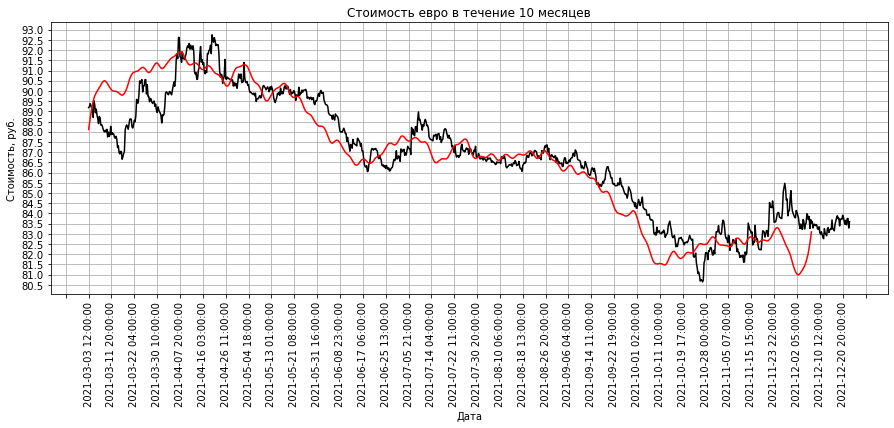

In [19]:
params = get_A_f(fourier, 0.05)
approximation = Function(0, trend.length * dt, dt)
approximation.complex_sin(params['A'], params['f'])
approximation.X = trend.X
approximation.Y = approximation.Y + trend.Y

Display.show_func_trend(file_1_hour, approximation, 30, 0.5, 90, 'Стоимость евро в течение 10 месяцев', 'Дата', 'Стоимость, руб.')

In [20]:
arr = np.array([trend.Y, file_1_hour.Y[:file_1_hour.length - L]], float)
corr = np.corrcoef(arr)
print('Correlation with trend:')
print(corr)

Correlation with trend:
[[1.         0.96105876]
 [0.96105876 1.        ]]


In [21]:
arr = np.array([restored.Y, file_1_hour.Y], float)
corr = np.corrcoef(arr)
print('Correlation with restored:')
print(corr)

Correlation with restored:
[[1.         0.94093637]
 [0.94093637 1.        ]]


In [22]:
arr = np.array([approximation.Y, file_1_hour.Y[:file_1_hour.length - L]], float)
corr = np.corrcoef(arr)
print('Correlation with approximation:')
print(corr)

Correlation with approximation:
[[1.        0.9412572]
 [0.9412572 1.       ]]


In [23]:
print(len(params['A']))
print(len(params['f']))

20
20


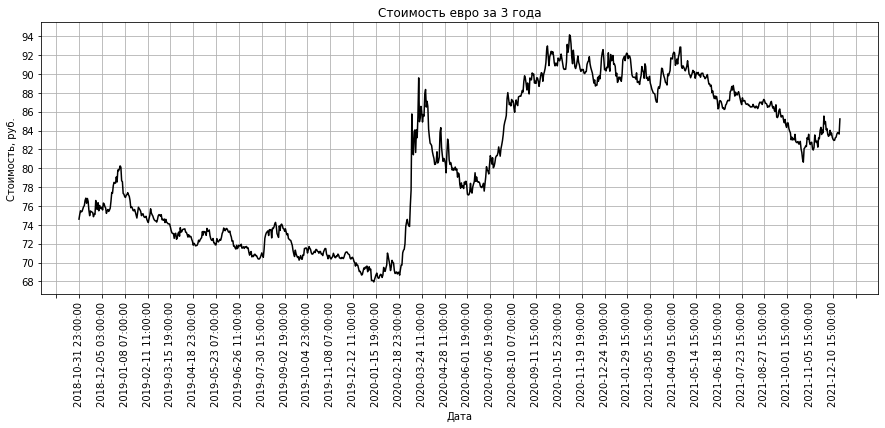

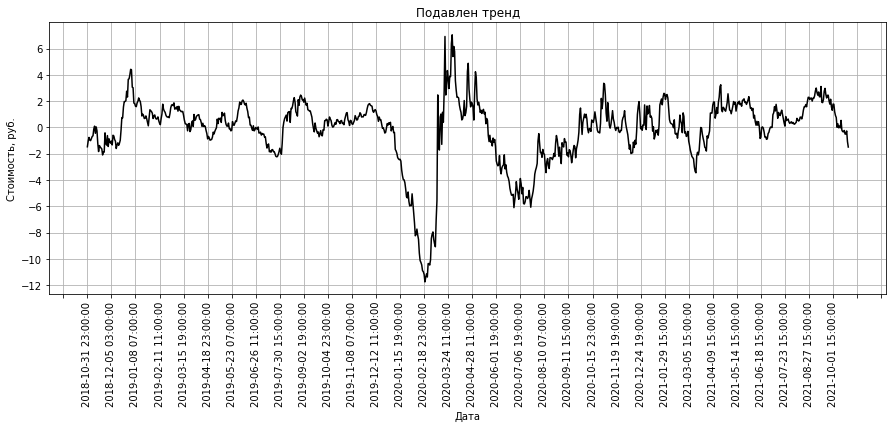

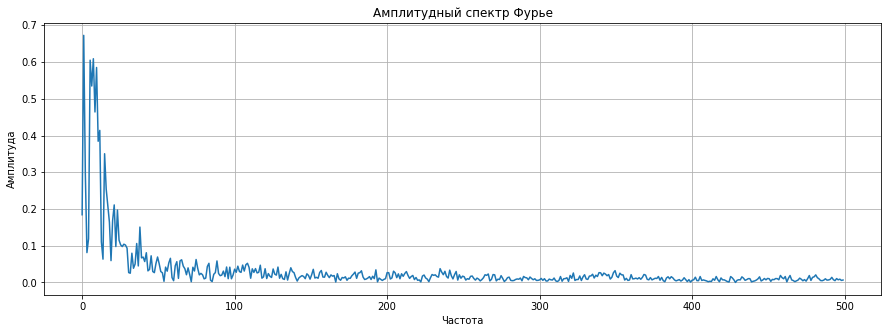

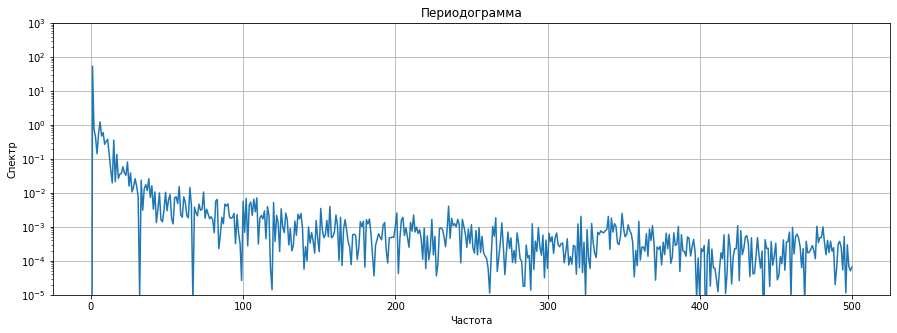

In [24]:
L = 50
start = 0
step = 1
window = 1
dt = 1 / 1000

# Курс доллара в течение 3 года
file_1_week = Function()
file_1_week.read('3_years_eur.txt', 'utf-8', "%d.%m.%Y %H")
file_1_week.convert_to_str('date')
file_1_week.reverse()
file_1_week.cut(5)

# Тренд курса доллара
trend = Function(start, file_1_week.length - L, step)
trend.trend(file_1_week)

Display.show(file_1_week, 30, 2, 90, 'Стоимость евро за 3 года', 'Дата', 'Стоимость, руб.')
# Display.show_func_trend(file_1_week, trend, 30, 2, 90, 'Стоимость доллара в течение 27 лет', 'Дата', 'Стоимость, руб.')

# Подавляется тренд
anti_trend = Function()
anti_trend.anti_trend(file_1_week, trend)

Display.show(anti_trend, 30, 2, 90, 'Подавлен тренд', 'Дата', 'Стоимость, руб.')

# Амплитудный спектр Фурье
fourier = Function(start, anti_trend.length, step)
fourier.fourier_spectrum(anti_trend, window, True, True, dt)
plt.figure(figsize=(15, 5))
fourier.display('Амплитудный спектр Фурье', 'Частота', 'Амплитуда')

# Фазовый спектр Фурье
phase = Function(start, anti_trend.length, step)
phase.phase_spectrum(anti_trend, window, True, True, dt)

# Периодограмма
plt.figure(figsize=(15, 5))
f, Pxx = signal.periodogram(file_1_week.Y, 1 / dt)
plt.semilogy(f, Pxx)
plt.ylim([1e-5, 1e3])
plt.title('Периодограмма')
plt.xlabel('Частота')
plt.ylabel('Спектр')
plt.grid(True)
plt.show()

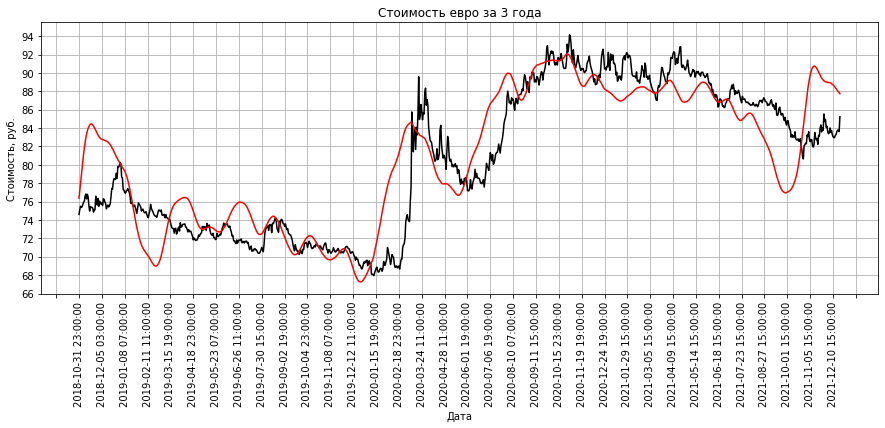

In [25]:
restored = Function(0, file_1_week.length * dt, dt)
restored.restore_signal(fourier, phase, 0.1)

restored.Y = restored.Y + np.array(list(trend.Y) + [trend.Y[trend.length - 1]] * L)
restored.X = file_1_week.X

Display.show_func_trend(file_1_week, restored, 30, 2, 90, 'Стоимость евро за 3 года', 'Дата', 'Стоимость, руб.')

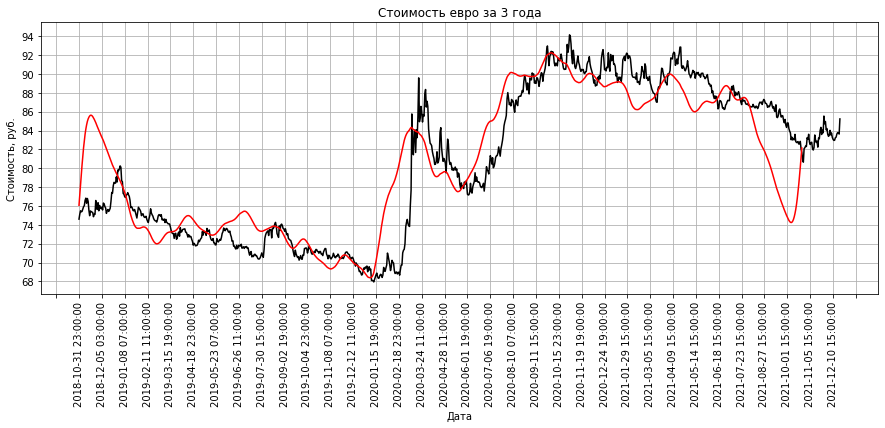

In [26]:
params = get_A_f(fourier, 0.1)
approximation = Function(0, trend.length * dt, dt)
approximation.complex_sin(params['A'], params['f'])
approximation.X = trend.X
approximation.Y = approximation.Y + trend.Y

Display.show_func_trend(file_1_week, approximation, 30, 2, 90, 'Стоимость евро за 3 года', 'Дата', 'Стоимость, руб.')

In [27]:
arr = np.array([trend.Y, file_1_week.Y[:file_1_week.length - L]], float)
corr = np.corrcoef(arr)
print('Correlation with trend:')
print(corr)

Correlation with trend:
[[1.         0.94882308]
 [0.94882308 1.        ]]


In [28]:
arr = np.array([restored.Y, file_1_week.Y], float)
corr = np.corrcoef(arr)
print('Correlation with restored:')
print(corr)

Correlation with restored:
[[1.         0.87049203]
 [0.87049203 1.        ]]


In [29]:
arr = np.array([approximation.Y, file_1_week.Y[:file_1_week.length - L]], float)
corr = np.corrcoef(arr)
print('Correlation with approximation:')
print(corr)

Correlation with approximation:
[[1.         0.88848029]
 [0.88848029 1.        ]]


In [30]:
print(len(params['A']))
print(len(params['f']))

24
24
